In [1]:
import numpy as np
import matplotlib

In [3]:
import dolfyn.adv.api as avm
import dolfyn.adv.turbulence as turb

In [4]:
matplotlib.use("Qt5Agg")
from PyQt5 import QtCore
from PyQt5.QtWidgets import QApplication, QMainWindow, QMenu, QVBoxLayout, QSizePolicy, QMessageBox, QWidget

In [5]:
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import matplotlib.pyplot as plt
import matplotlib.dates as dt
import matplotlib.ticker as mtick
import os.path

In [6]:
import urllib2

In [7]:
fname = '/Users/lillie/turbulence_data/raw_data/TTM_NREL03_May2015'
body2head_vec = np.array([9.75, 2, -5.75]) * 0.0254
body2head_rotmat = np.array([[0, 0, -1], [0, -1, 0], [-1, 0, 0]])
accel_filter = 0.1
load_vec = True

In [8]:
%%time
#If the file exists...

#....as an '.h5' file, read it
if os.path.isfile(fname + '.h5'):
    dat_raw = avm.load(fname + '.h5')
#....as a '.VEC' file, save it as an '.h5' and then read it using dolfyn library
elif os.path.isfile(fname + ',VEC'):
    dat_raw = avm.read_nortek(fname + '.VEC')
    dat_raw.save(fname + '.h5')  

# If the file does not exist as either a '.VEC' or '.h5', download it from the internet, save it as a '.h5' file and read it
else:
    file = 'TTM_NREL03_May2015.VEC'
    url = 'https://mhkdr.openei.org/files/51/TTM_NREL03_May2015.VEC'
    response = urllib2.urlopen(url)
    with open(file, 'wb') as f: 
        f.write(response.read())
    dat_raw = avm.read_nortek(data)
    dat_raw.save(fname + '.h5')   

CPU times: user 1.51 s, sys: 319 ms, total: 1.83 s
Wall time: 4.71 s


In [9]:
x_start = .00835 + 7.3572944e5
x_end = .304 + 7.35731e5
t_range = [x_start, x_end]
t_range

[735729.44835, 735731.304]

In [10]:
t_range_inds = (t_range[0] < dat_raw.mpltime) & (dat_raw.mpltime < t_range[1])
dat_crop = dat_raw.subset(t_range_inds)
dat_crop.props['body2head_vec'] = body2head_vec
dat_crop.props['body2head_rotmat'] = body2head_rotmat

In [11]:
%%time
t_range_inds = (t_range[0] < dat_raw.mpltime) & (dat_raw.mpltime < t_range[1])
dat = dat_raw.subset(t_range_inds)
dat.props['body2head_vec'] = body2head_vec
dat.props['body2head_rotmat'] = body2head_rotmat

# Then clean the file using the Goring+Nikora method:
avm.clean.GN2002(dat)
dat_cln = dat.copy()

CPU times: user 55.3 s, sys: 5.14 s, total: 1min
Wall time: 1min 2s


In [12]:
avm.motion.correct_motion(dat_crop, accel_filter)

# Rotate the uncorrected data into the earth frame,
# for comparison to motion correction:
avm.rotate.inst2earth(dat_cln)

# ax.plot(dat.mpltime, dat.u, 'b-')

# Then rotate it into a 'principal axes frame':
avm.rotate.earth2principal(dat_crop)
avm.rotate.earth2principal(dat_cln)


<IPython.core.display.Javascript object>


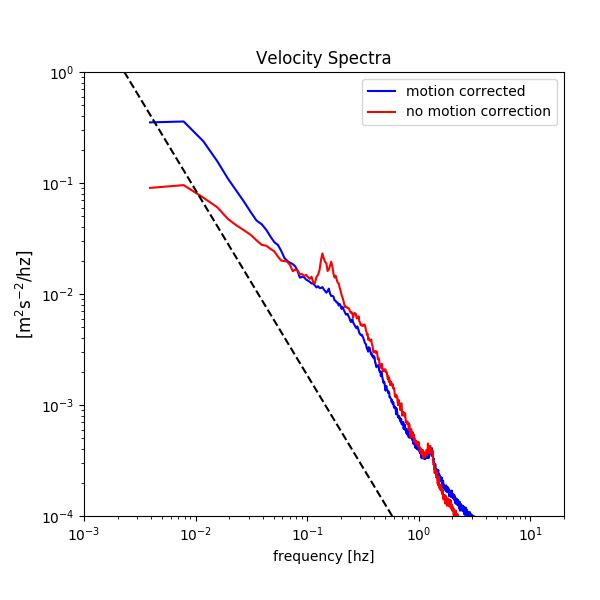

CPU times: user 4.06 s, sys: 460 ms, total: 4.52 s
Wall time: 4.81 s


In [13]:
%%time
%matplotlib nbagg
# Average the data and compute turbulence statistics
dat_bin = avm.calc_turbulence(dat, n_bin=19200,
                                n_fft=4096)
dat_cln_bin = avm.calc_turbulence(dat_cln, n_bin=19200,
                                    n_fft=4096)

fig = plt.figure(2, figsize=[6, 6])
fig.clf()
ax = fig.add_axes([.14, .14, .8, .74])

ax.loglog(dat_bin.freq, dat_bin.Suu_hz.mean(0),
            'b-', label='motion corrected')
ax.loglog(dat_cln_bin.freq, dat_cln_bin.Suu_hz.mean(0),
            'r-', label='no motion correction')

ax.set_xlim([1e-3, 20])
ax.set_ylim([1e-4, 1])
ax.set_xlabel('frequency [hz]')
ax.set_ylabel('$\mathrm{[m^2s^{-2}/hz]}$', size='large')

f_tmp = np.logspace(-3, 1)
ax.plot(f_tmp, 4e-5 * f_tmp ** (-5. / 3), 'k--')

ax.set_title('Velocity Spectra')
ax.legend()

plt.show()

In [23]:
!pip install PyTurbSim

  Using cached PyTurbSim-0.4.7.tar.gz
  Running setup.py bdist_wheel for PyTurbSim ... - \ | error
  Complete output from command /Users/lillie/anaconda/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/bq/fb7tz2t148q130j_jbgchmrm0000gq/T/pip-build-lG6B16/PyTurbSim/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /var/folders/bq/fb7tz2t148q130j_jbgchmrm0000gq/T/tmpeBUy0Ypip-wheel- --python-tag cp27:
  running bdist_wheel
  running build
  running config_cc
  unifing config_cc, config, build_clib, build_ext, build commands --compiler options
  running config_fc
  unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
  running build_src
  build_src
  building extension "pyts.tslib" sources
  f2py options: []
    adding 'build/src.macosx-10.7-x86_64-2.7/fortranobject.c' to sources.
    adding 'build/src.macosx-10.7-x86_64-

/bin/sh: pyTurbSim.py: command not found


ImportError: No module named pyts.api